# Pytorch神经网络入门：单车预测器（一）
## 2021.10.2  Leakey

## 一、单车预测模型（初代）

### 1.设置环境，建立模型

In [1]:
import numpy as np
import pandas as pd             #用于读取.csv文件
import torch
from torch.autograd import Variable
import torch.optim as optim     #优化算法库
import matplotlib.pyplot as plt #绘图工具包
%matplotlib inline

初始化

In [2]:
import os   #内核防挂
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

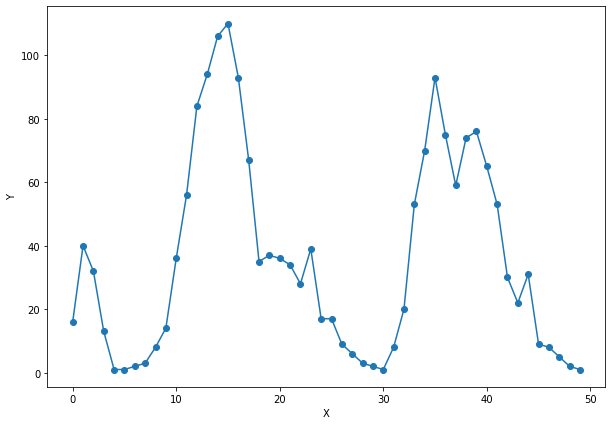

In [30]:
data_path = 'hour.csv'
rides =pd.read_csv(data_path)
rides.head()

counts = rides['cnt'][:50]

x = np.arange(len(counts))
y = np.array(counts)

plt.figure(figsize=(10,7))
plt.plot(x,y,'o-')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [34]:
#x = Variable(torch.FloatTensor(np.arange(len(counts),dtype = float)))
#y = Variable(torch.FloatTensor(np.array(counts,dtype = float)))

In [51]:
#weights = Variable(torch.randn(1,sz),requires_grad = True)
#[高斯随机]初始化权重w，赋予梯度

#biases = Variable(torch.randn(sz),requires_grad = True)
#[完全随机]初始化隐含层偏置量b，赋予梯度

#weights2 = Variable(torch.randn(sz,1),requires_grad = True)
#[高斯随机]初始化权重w'，赋予梯度

↑↑书上的方法：用封装的Variable初始化x,y张量以及各权重等变量

（注：此方法在测试中有问题，梯度下降难以达到理想效果，不如用未封装的tensor赋予梯度直接定义）

其中：x作为输入变量，y作为标准答案（实际值）

#### 实际的参数初始化方法（只要加梯度就好用）：

In [55]:
counts = rides['cnt'][:50]
#截取数据

x = torch.tensor(np.arange(len(counts), dtype = float), requires_grad = True)
#与书上不同，此处直接用torch.tensor创建张量，并赋予梯度
#创建与长度相对应的数字(1,2,3,...,50)，类型为float
y = torch.tensor(np.array(counts, dtype = float), requires_grad = True)
#创建一维数组，内涵截取的数据数据counts，类型为float

# 初始化所有神经网络的权重（weights）和阈值（biases）
weights = torch.randn((1, sz), dtype = torch.double, requires_grad = True)
#[高斯随机]初始化权重w，赋予梯度，1*10的输入到隐含层的权重矩阵
biases = torch.randn(sz, dtype = torch.double, requires_grad = True)
#[完全随机]初始化隐含层偏置量b，赋予梯度，尺度为10的隐含层节点偏置向量
weights2 = torch.randn((sz, 1), dtype = torch.double, requires_grad = True)
#[高斯随机]初始化权重w'，赋予梯度，10*1的隐含到输出层权重矩阵

#利用view赋予形状

#将x转换为(50,1)的维度
x = x.view(50, -1)
#将y转换为(50,1)的维度
y = y.view(50, -1)


### 2.开始学习

In [52]:
sz = 10
# 设置隐含层神经元的数量

learning_rate = 0.001
#设置学习率

losses = []
#用于记录损失函数的值

for i in range(100000):

    hidden = x * weights + biases
    #hidden尺寸为(50,10)，有50个数据点，10个隐含层神经元
    
    hidden = torch.sigmoid(hidden)
    #将sigmoid函数作用于隐含层
    
    predictions = hidden.mm(weights2)
    #此时predictions尺寸为(50,1)，即50个数据点的预测值
    
    loss = torch.mean((predictions - y) ** 2)
    
    losses.append(loss.data.numpy())
    
    if i%10000 == 0:
        print('loss:',loss,'i =',i)
        
    #预测，损失已计算，接下来开始梯度下降，反传误差
    loss.backward()
    
    weights.data.add_(- learning_rate * weights.grad.data)
    biases.data.add_(- learning_rate * biases.grad.data)
    weights2.data.add_(- learning_rate * weights2.grad.data)
    
    #清空梯度，准备进入下一轮循环
    weights.grad.data.zero_()
    biases.grad.data.zero_()
    weights2.grad.data.zero_()

loss: tensor(2264.0682, dtype=torch.float64, grad_fn=<MeanBackward0>) i = 0
loss: tensor(641.6290, dtype=torch.float64, grad_fn=<MeanBackward0>) i = 10000
loss: tensor(506.5497, dtype=torch.float64, grad_fn=<MeanBackward0>) i = 20000
loss: tensor(477.0864, dtype=torch.float64, grad_fn=<MeanBackward0>) i = 30000
loss: tensor(463.8880, dtype=torch.float64, grad_fn=<MeanBackward0>) i = 40000
loss: tensor(458.8727, dtype=torch.float64, grad_fn=<MeanBackward0>) i = 50000
loss: tensor(456.8804, dtype=torch.float64, grad_fn=<MeanBackward0>) i = 60000
loss: tensor(456.0874, dtype=torch.float64, grad_fn=<MeanBackward0>) i = 70000
loss: tensor(455.7168, dtype=torch.float64, grad_fn=<MeanBackward0>) i = 80000
loss: tensor(455.5569, dtype=torch.float64, grad_fn=<MeanBackward0>) i = 90000


Text(0, 0.5, 'Loss')

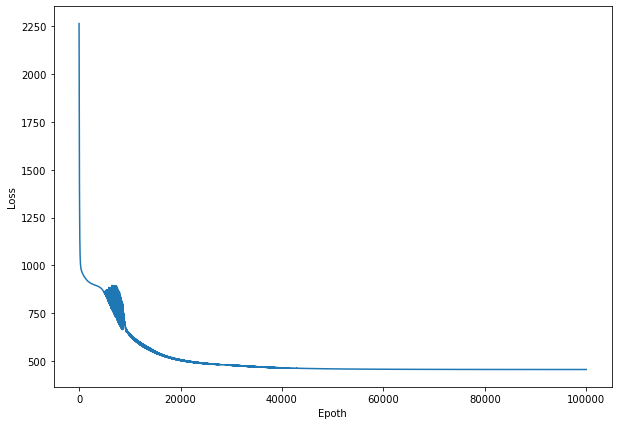

In [53]:
plt.figure(figsize = (10,7))
plt.plot(losses)
plt.xlabel('Epoth')
plt.ylabel('Loss')

可见，误差loss停留在1010左右

### 3.预测

<function matplotlib.pyplot.show(close=None, block=None)>

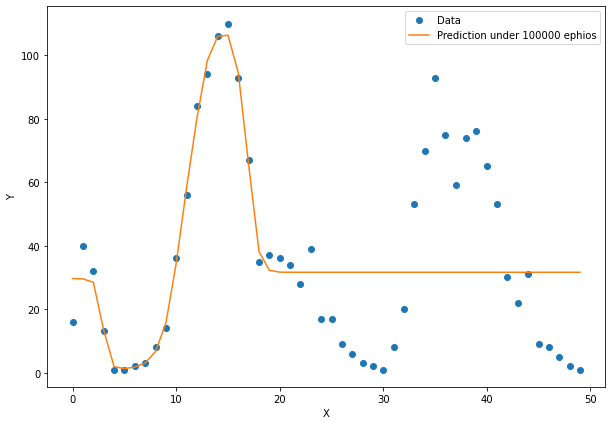

In [54]:
x_data = x.data.numpy()
plt.figure(figsize = (10,7))
xplot, = plt.plot(x_data, y.data.numpy(),'o')
yplot, = plt.plot(x.data, predictions.data.numpy())
plt.xlabel('X')
plt.ylabel('Y')
plt.legend([xplot,yplot],['Data','Prediction under 100000 ephios'])
plt.show

可以发现，拟合了但没完全拟合，效果较差

### 4.改进模型

#### 参数初始化，此过程将x归一化处理

In [57]:
counts = rides['cnt'][:50]
#截取数据

x = torch.tensor(np.arange(len(counts), dtype = float) / len(counts), requires_grad = True)
#与书上不同，此处直接用torch.tensor创建张量，并赋予梯度
#创建与长度相对应的数字(1,2,3,...,50)，类型为float
y = torch.tensor(np.array(counts, dtype = float), requires_grad = True)
#创建一维数组，内涵截取的数据数据counts，类型为float

# 初始化所有神经网络的权重（weights）和阈值（biases）
weights = torch.randn((1, sz), dtype = torch.double, requires_grad = True)
#[高斯随机]初始化权重w，赋予梯度，1*10的输入到隐含层的权重矩阵
biases = torch.randn(sz, dtype = torch.double, requires_grad = True)
#[高斯随机]初始化隐含层偏置量b，赋予梯度，尺度为10的隐含层节点偏置向量
weights2 = torch.randn((sz, 1), dtype = torch.double, requires_grad = True)
#[高斯随机]初始化权重w'，赋予梯度，10*1的隐含到输出层权重矩阵

#利用view赋予形状

#将x转换为(50,1)的维度
x = x.view(50, -1)
#将y转换为(50,1)的维度
y = y.view(50, -1)


### 5.再次学习

In [58]:
sz = 10
# 设置隐含层神经元的数量

learning_rate = 0.001
#设置学习率

losses = []
#用于记录损失函数的值

for i in range(100000):

    hidden = x * weights + biases
    #hidden尺寸为(50,10)，有50个数据点，10个隐含层神经元
    
    hidden = torch.sigmoid(hidden)
    #将sigmoid函数作用于隐含层
    
    predictions = hidden.mm(weights2)
    #此时predictions尺寸为(50,1)，即50个数据点的预测值
    
    loss = torch.mean((predictions - y) ** 2)
    
    losses.append(loss.data.numpy())
    
    if i%10000 == 0:
        print('loss:',loss,'i =',i)
        
    #预测，损失已计算，接下来开始梯度下降，反传误差
    loss.backward()
    
    weights.data.add_(- learning_rate * weights.grad.data)
    biases.data.add_(- learning_rate * biases.grad.data)
    weights2.data.add_(- learning_rate * weights2.grad.data)
    
    #清空梯度，准备进入下一轮循环
    weights.grad.data.zero_()
    biases.grad.data.zero_()
    weights2.grad.data.zero_()

loss: tensor(2396.4968, dtype=torch.float64, grad_fn=<MeanBackward0>) i = 0
loss: tensor(917.9345, dtype=torch.float64, grad_fn=<MeanBackward0>) i = 10000
loss: tensor(677.6920, dtype=torch.float64, grad_fn=<MeanBackward0>) i = 20000
loss: tensor(461.0182, dtype=torch.float64, grad_fn=<MeanBackward0>) i = 30000
loss: tensor(220.6828, dtype=torch.float64, grad_fn=<MeanBackward0>) i = 40000
loss: tensor(126.0433, dtype=torch.float64, grad_fn=<MeanBackward0>) i = 50000
loss: tensor(84.3953, dtype=torch.float64, grad_fn=<MeanBackward0>) i = 60000
loss: tensor(62.9392, dtype=torch.float64, grad_fn=<MeanBackward0>) i = 70000
loss: tensor(52.6978, dtype=torch.float64, grad_fn=<MeanBackward0>) i = 80000
loss: tensor(47.3483, dtype=torch.float64, grad_fn=<MeanBackward0>) i = 90000


### 6.再次预测

<function matplotlib.pyplot.show(close=None, block=None)>

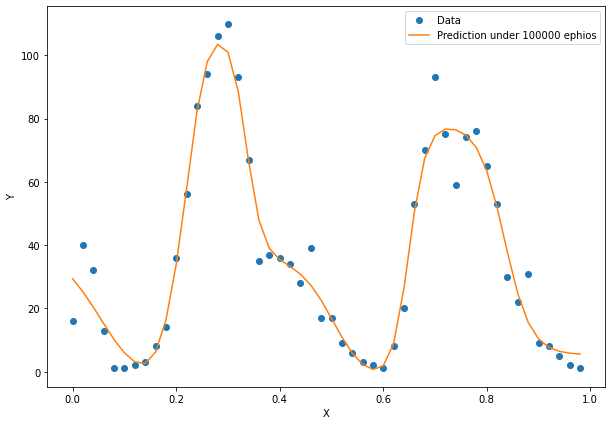

In [59]:
x_data = x.data.numpy()
plt.figure(figsize = (10,7))
xplot, = plt.plot(x_data, y.data.numpy(),'o')
yplot, = plt.plot(x.data, predictions.data.numpy())
plt.xlabel('X')
plt.ylabel('Y')
plt.legend([xplot,yplot],['Data','Prediction under 100000 ephios'])
plt.show

#### 可见，拟合效果较好。

观察权重与偏置量可知，其初始化的数值都是[0,1]之间的随机数，它们将作用于x，但x的变化范围为[1,50]，其量级差别较大，难以快速调节各部分参数使之获得较好的学习效果。

但理论上说，只要时间足够长，不归一化处理的x也可以使整个模型拟合，但需要的时间太长，应用性很差。

将x归一化会使其在初始化的时候限制在[0,1]之间，学习效率有所提高。

### 7：应用模型

In [61]:
counts_predict = rides['cnt'][50:100]
#取数据

x = torch.tensor(np.arange(len(counts_predict), dtype = float) / len(counts), requires_grad = True)
y = torch.tensor(np.array(counts_predict, dtype = float), requires_grad = True)
#输入量、准确答案赋值

x = x.view(50, -1)
y = y.view(50, -1)
#view，转换维度

hidden = x * weights + biases
hidden = torch.sigmoid(hidden)
predictions = hidden.mm(weights2)
#计算、预测
#此过程并非学习过程，没有调参，直接使用

loss = torch.mean((predictions - y) ** 2)
print('loss',loss)
#损失函数

loss tensor(4150.4740, dtype=torch.float64, grad_fn=<MeanBackward0>)


<function matplotlib.pyplot.show(close=None, block=None)>

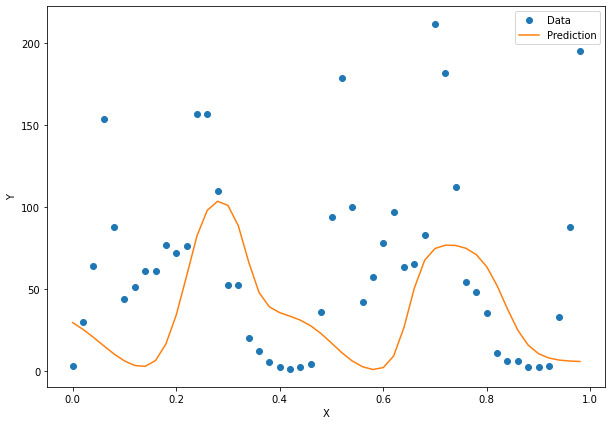

In [62]:
x_data = x.data.numpy()
plt.figure(figsize = (10,7))
xplot, = plt.plot(x_data, y.data.numpy(),'o')
yplot, = plt.plot(x.data, predictions.data.numpy())
plt.xlabel('X')
plt.ylabel('Y')
plt.legend([xplot,yplot],['Data','Prediction'])
plt.show

#### 可见，拟合很差。
原因：过拟合（程度没有书上那么严重，但也很严重）

我们选择了出错误的特征变量（日期），但实际上单车使用情况不仅与日期相关，还与天气、风速、节假日等特征相关，我们应该考虑这些特征而非简单的日期。